# 1. Introduction



In [15]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import StratifiedKFold,cross_validate, cross_val_predict
from sklearn.metrics import roc_auc_score, roc_auc_score, brier_score_loss, RocCurveDisplay, accuracy_score
from sklearn.preprocessing import StandardScaler
from imblearn.pipeline import Pipeline 
from sklearn.calibration import CalibrationDisplay

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler


#data = pd.read_csv('/Users/hungduong/Documents/MSBA UofU/MSBA 4th/MKTG 6620/churn_train.csv')
#data = pd.read_csv(r'C:\Users\dhung\OneDrive\Documents\asking people for job\cody\ML_churn_predict\churn_train.csv')


### Business Problem

### Leakage Policy

### Data overview and EDA

In [2]:
# Data highview
pd.set_option('display.max_columns', None)
data.head()

,ID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,yrhdgfy_4741,Male,0,No,No,35,No,No phone service,DSL,No,No,Yes,No,Yes,Yes,Month-to-month,No,Electronic check,49.20,1701.65,No
1,yrhdgfy_4154,Male,0,Yes,Yes,15,Yes,No,Fiber optic,Yes,No,No,No,No,No,Month-to-month,No,Mailed check,75.10,1151.55,No
2,yrhdgfy_5863,Male,0,Yes,Yes,13,No,No phone service,DSL,Yes,Yes,No,Yes,No,No,Two year,No,Mailed check,40.55,590.35,No
3,yrhdgfy_4870,Female,0,Yes,No,26,Yes,No,DSL,No,Yes,Yes,No,Yes,Yes,Two year,Yes,Credit card (automatic),73.50,1905.7,No
4,yrhdgfy_4813,Male,0,Yes,Yes,1,Yes,No,DSL,No,No,No,No,No,No,Month-to-month,No,Electronic check,44.55,44.55,No


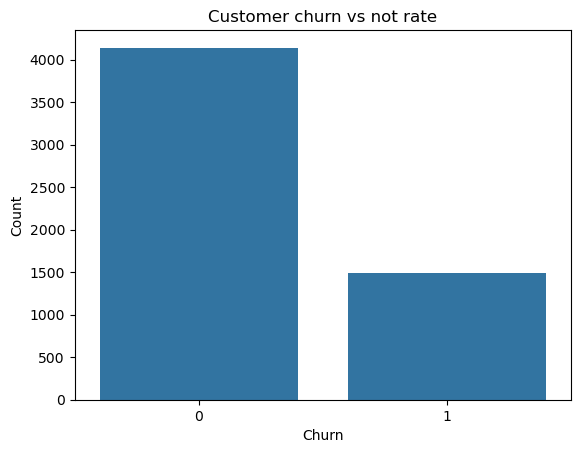

Churn rate is 26.54%


In [3]:
# Looks at Target variable
data['Churn'] = data['Churn'].map({'No':0, 'Yes':1})

sns.countplot(x='Churn', data=data)
plt.title('Customer churn vs not rate')
plt.xlabel('Churn')
plt.ylabel('Count')
plt.show()

#Target rate is imbalance
print(f"Churn rate is {data['Churn'].mean() * 100:.2f}%")


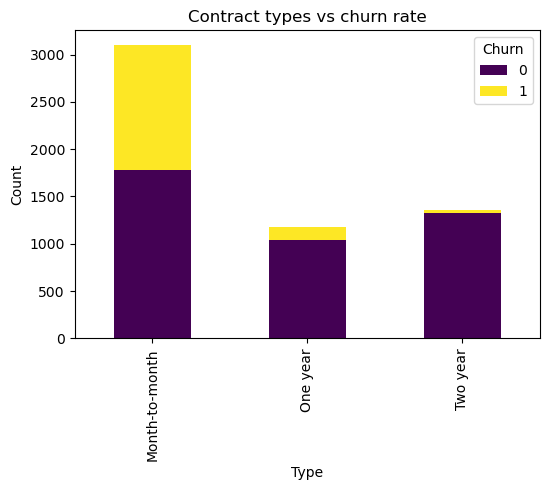

In [4]:
# How do contract type correlate with Churn?
pd.crosstab(data['Contract'], data['Churn']).plot(
    kind='bar',
    stacked=True,
    figsize=(6,4),
    colormap='viridis'
)

plt.title('Contract types vs churn rate')
plt.xlabel('Type')
plt.ylabel('Count')
plt.show()

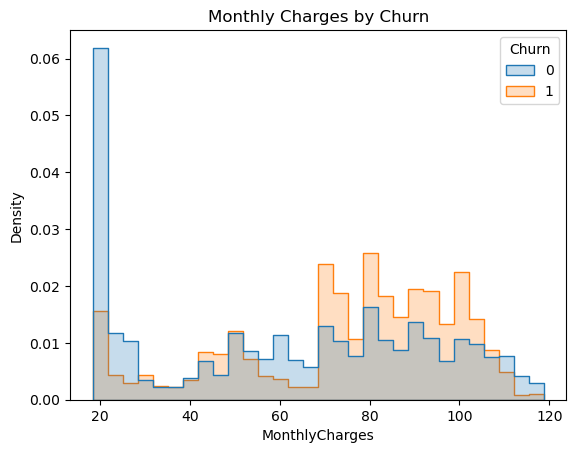

In [5]:
# How do monthly charges influence Churn?
sns.histplot(data=data, x='MonthlyCharges', hue='Churn',
             bins=30, stat='density', common_norm=False, element='step')
plt.title('Monthly Charges by Churn')
plt.xlabel('MonthlyCharges')
plt.ylabel('Density')
plt.show()

This plot is showing that people with low monthly charges tends not to churn, around $20-$40.


However, the group that churn the most seems to be high monthly charges ones noticeably around $70-$110.

# 2. Machine Learning

### Data preparation


In [6]:
# Prepare data for ML
data_ml = data.copy()

# get dummies variable
data_ml = pd.get_dummies(
    data_ml,
    columns=[
        'gender','SeniorCitizen','Partner','Dependents','PhoneService','MultipleLines',
        'InternetService','OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport',
        'StreamingTV','StreamingMovies','Contract','PaperlessBilling','PaymentMethod'
    ],
    drop_first=True  #
)

# Fix total charges dtype
data_ml['TotalCharges'] = pd.to_numeric(data_ml['TotalCharges'], errors='coerce').fillna(0)

# Check dtype
data_ml.dtypes

ID                                        object
tenure                                     int64
MonthlyCharges                           float64
TotalCharges                             float64
Churn                                      int64
gender_Male                                 bool
SeniorCitizen_1                             bool
Partner_Yes                                 bool
Dependents_Yes                              bool
PhoneService_Yes                            bool
MultipleLines_No phone service              bool
MultipleLines_Yes                           bool
InternetService_Fiber optic                 bool
InternetService_No                          bool
OnlineSecurity_No internet service          bool
OnlineSecurity_Yes                          bool
OnlineBackup_No internet service            bool
OnlineBackup_Yes                            bool
DeviceProtection_No internet service        bool
DeviceProtection_Yes                        bool
TechSupport_No inter

In [7]:
# Split data 
x = data_ml.drop(columns=['Churn', 'ID']) 
y = data_ml['Churn'] 
cv = StratifiedKFold(5, shuffle=True, random_state=111)

### Simple baseline Logistic Model

In [8]:
# Logistic model with penalty Lasso Ridge
log_pipe = Pipeline(
    [("scaler", StandardScaler()), 
     ("logreg", LogisticRegression(penalty='elasticnet', C=1.0, 
                                   solver='saga', l1_ratio=0.5, 
                                   max_iter=1000, 
                                   class_weight='balanced' # handle class imbalance
                                   ))])

log_model_scores = cross_validate(
    log_pipe, x, y, 
    cv=cv, 
    scoring={'roc': 'roc_auc', 'acc': 'accuracy', 'f1': 'f1'}, 
    return_train_score=False )



In [9]:
# Result 
print(pd.DataFrame(log_model_scores)[['test_roc','test_acc','test_f1']].mean().round(3)) 

# Discrimination - AUC and Brier Score 
log_model_prob = cross_val_predict(log_pipe, x, y, cv=cv, method='predict_proba')[:, 1] 
auc_oof = roc_auc_score(y, log_model_prob) 
brier_oof = brier_score_loss(y, log_model_prob, pos_label=1) 

print(f"Discrimination AUC: {auc_oof:.3f}") 
print(f"Calibration Brier: {brier_oof:.4f}") 


# Feature importance 
log_pipe.fit(x, y) 
coef_table = pd.DataFrame({ "Feature": x.columns, "Coefficient": log_pipe.named_steps["logreg"].coef_.flatten() }) 
pd.set_option('display.max_rows', None) 
print(coef_table)

test_roc    0.845
test_acc    0.750
test_f1     0.629
dtype: float64
Discrimination AUC: 0.845
Calibration Brier: 0.1653
                                  Feature  Coefficient
0                                  tenure    -1.150568
1                          MonthlyCharges    -0.827809
2                            TotalCharges     0.483840
3                             gender_Male     0.015588
4                         SeniorCitizen_1     0.056214
5                             Partner_Yes     0.007985
6                          Dependents_Yes    -0.103980
7                        PhoneService_Yes     0.003059
8          MultipleLines_No phone service    -0.003059
9                       MultipleLines_Yes     0.184329
10            InternetService_Fiber optic     0.725010
11                     InternetService_No    -0.088430
12     OnlineSecurity_No internet service    -0.088430
13                     OnlineSecurity_Yes    -0.129364
14       OnlineBackup_No internet service    -0.088430

### Random Forest

In [10]:
rf_model = RandomForestClassifier(
    n_estimators=300,      
    max_depth=10,        
    random_state=42,       
    class_weight='balanced',  # handle class imbalance
    n_jobs=-1              
)

rf_model_scores = cross_validate(
    rf_model, x, y,
    cv=cv, 
    scoring={'roc': 'roc_auc', 'acc': 'accuracy', 'f1': 'f1'}, 
    return_train_score=False
)

In [11]:
# Result 
print(pd.DataFrame(rf_model_scores)[['test_roc','test_acc','test_f1']].mean().round(3)) 

# Discrimination - AUC and Brier Score 
rf_model_prob = cross_val_predict(rf_model, x, y, cv=cv, method='predict_proba')[:, 1] 
auc_oof = roc_auc_score(y, rf_model_prob) 
brier_oof = brier_score_loss(y, rf_model_prob, pos_label=1) 

print(f"Discrimination AUC: {auc_oof:.3f}") 
print(f"Calibration Brier: {brier_oof:.4f}") 

test_roc    0.844
test_acc    0.780
test_f1     0.633
dtype: float64
Discrimination AUC: 0.844
Calibration Brier: 0.1479



### Gradient Boosting Tree

In [16]:
# Train GBT model 
gbt_pipe = Pipeline(steps=[
    ('smote', RandomUnderSampler(random_state=42)),   # Undersample for a balance train data
    ('gbt', GradientBoostingClassifier(
        learning_rate=0.01, n_estimators=800, max_depth=3,
        subsample=1.0, max_features='log2', random_state=42
    ))
])

gbt_pipe_scores = cross_validate(
    gbt_pipe, x, y, cv=cv,
    scoring={'roc':'roc_auc', 'acc':'accuracy', 'f1':'f1'},
    return_train_score=True
)


In [17]:
# Result from CV
print(pd.DataFrame(gbt_pipe_scores)[['test_roc','test_acc','test_f1']].mean().round(3)) 

# Get Out of fold results
oof_proba = cross_val_predict(
    gbt_pipe, x, y, cv=cv, method='predict_proba'
)[:, 1]

# Metrics on OOF probs
auc_oof   = roc_auc_score(y, oof_proba)          # discrimination AUC
brier_oof = brier_score_loss(y, oof_proba)       # calibration 

print(f"OOF ROC-AUC: {auc_oof:.3f}")
print(f"OOF Brier : {brier_oof:.4f}")

test_roc    0.848
test_acc    0.750
test_f1     0.632
dtype: float64
OOF ROC-AUC: 0.848
OOF Brier : 0.1618


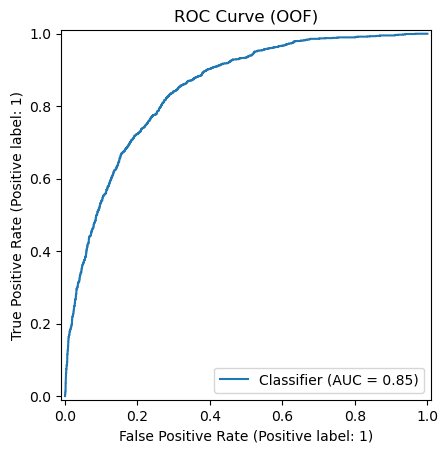

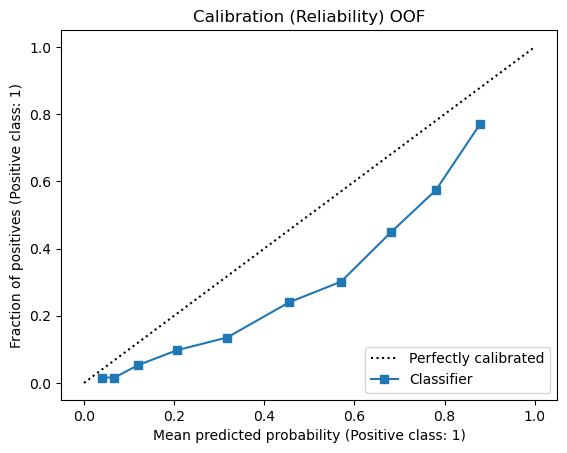

In [18]:
# Plots out of fold ROC
RocCurveDisplay.from_predictions(y, oof_proba)
plt.title("ROC Curve (OOF)"); plt.show()

# Plot out of fold calibration
CalibrationDisplay.from_predictions(y, oof_proba, n_bins=10, strategy='quantile')
plt.title("Calibration (Reliability) OOF"); plt.show()

### Best model

| Model                   |  ROC-AUC  |  Accuracy |  F1-Score |   Brier   | Interpretation                                                         |
| ----------------------- | :-------: | :-------: | :-------: | :-------: | :--------------------------------------------------------------------- |
| **Gradient Boosting**   | **0.848** |   0.750   |   0.632   |   0.162   | Best raw discrimination (top AUC), slightly less calibrated            |
| **Random Forest**       |   0.844   | **0.780** | **0.633** | **0.148** | Best overall — balanced accuracy & F1, and most reliable probabilities |
| **Logistic Regression** |   0.845   |   0.750   |   0.629   |   0.165   | Simple and interpretable, performs close to the others                 |



With the goal of identifying which customers are most likely to churn, the ranking capability of the Gradient Boosting model enables the retention team to prioritize outreach. Its high ROC-AUC score reflecting the model’s ability to rank churners higher than non-churners, allows the team to first contact customers with the highest predicted churn probability, then move down the list until the budget limit is reached.

Meanwhile, to generate a reliable churn probability score for each active customer, I recommend using the Random Forest model. Its lower Brier score indicates better calibration, meaning the model’s predicted probabilities closely match the actual outcomes.

### Ablation table

In [ ]:
# --- Full model metrics
oof_full = cross_val_predict(gbt_pipe, x, y, cv=cv, method='predict_proba')[:, 1]
auc_full, brier_full = roc_auc_score(y, oof_full), brier_score_loss(y, oof_full)

# --- Groups
groups = {
    "Demographics": [
        "gender_Male", "SeniorCitizen_1", "Partner_Yes", "Dependents_Yes"
    ],
    "Core_Access": [
        "PhoneService_Yes", "MultipleLines_No phone service", "MultipleLines_Yes",
        "InternetService_Fiber optic", "InternetService_No"
    ],
    "AddOns_Streaming": [
        "OnlineSecurity_No internet service", "OnlineSecurity_Yes",
        "OnlineBackup_No internet service", "OnlineBackup_Yes",
        "DeviceProtection_No internet service", "DeviceProtection_Yes",
        "TechSupport_No internet service", "TechSupport_Yes",
        "StreamingTV_No internet service", "StreamingTV_Yes",
        "StreamingMovies_No internet service", "StreamingMovies_Yes"
    ],
    "Contracts_Billing": [
        "Contract_One year", "Contract_Two year", "PaperlessBilling_Yes",
        "PaymentMethod_Credit card (automatic)",
        "PaymentMethod_Electronic check", "PaymentMethod_Mailed check",
        "MonthlyCharges", "TotalCharges"
    ]
}


rows = []
for name, cols in groups.items():
    X_drop = x.drop(columns=cols, errors="ignore")
    oof_proba = cross_val_predict(gbt_pipe, X_drop, y, cv=cv, method='predict_proba')[:, 1]
    oof_pred = (oof_proba >= 0.5).astype(int)  # threshold = 0.5
    
    auc = roc_auc_score(y, oof_proba)
    brier = brier_score_loss(y, oof_proba)
    acc = accuracy_score(y, oof_pred)
    
    rows.append([name, auc, brier, acc])

# --- Full model metrics
oof_full = cross_val_predict(gbt_pipe, x, y, cv=cv, method='predict_proba')[:, 1]
oof_pred_full = (oof_full >= 0.5).astype(int)
auc_full = roc_auc_score(y, oof_full)
brier_full = brier_score_loss(y, oof_full)
acc_full = accuracy_score(y, oof_pred_full)

# --- Make table
ablation = pd.DataFrame(rows, columns=["Removed_Group","AUC","Brier","Accuracy"])
ablation["Delta AUC"] = ablation["AUC"] - auc_full            # AUC no group vs full model 
ablation["Delta Brier"] = ablation["Brier"] - brier_full
ablation["Delta Accuracy"] = ablation["Accuracy"] - acc_full

full = pd.DataFrame(
    [["Full Model", auc_full, brier_full, acc_full, 0, 0, 0]],
    columns=ablation.columns
)
ablation_table = pd.concat([full, ablation], ignore_index=True)

print(ablation_table.round(4))

       Removed_Group     AUC   Brier  Accuracy  Delta AUC  Delta Brier  \
0         Full Model  0.8478  0.1618    0.7504     0.0000       0.0000   
1       Demographics  0.8481  0.1618    0.7481     0.0002       0.0000   
2        Core_Access  0.8462  0.1630    0.7497    -0.0017       0.0012   
3   AddOns_Streaming  0.8445  0.1636    0.7457    -0.0034       0.0018   
4  Contracts_Billing  0.8355  0.1676    0.7370    -0.0123       0.0059   

   Delta Accuracy  
0          0.0000  
1         -0.0023  
2         -0.0007  
3         -0.0048  
4         -0.0135  


The most important groups are - in order: 
* Contracts_Billing: Due to largest drop in Delta AUC (-0.0123), Delta Brier (0.059) and accuracy (-0.0135)
* AddOns_Streaming
* Core_Access
* Demographics: Have the smallest drop in predictability of the Gradient Boosted Tree model, with Delta AUC increase (0.0002), Delata Brier (0) and Delta Accuracy (-0.0023)

The only excluding group that might improve model performance is the Demographics group; with the increase of Delta AUC 0.0002.

# 3. Holdout data

In [ ]:
# Data pipeline prep
holdout_data = pd.read_csv(' ')

holdout_data = pd.get_dummies(
    holdout_data,
    columns=[
        'gender','SeniorCitizen','Partner','Dependents','PhoneService','MultipleLines',
        'InternetService','OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport',
        'StreamingTV','StreamingMovies','Contract','PaperlessBilling','PaymentMethod'
    ],
    drop_first=True 
)

# Fix total charges dtype
holdout_data['TotalCharges'] = pd.to_numeric(holdout_data['TotalCharges'], errors='coerce').fillna(0)


# Mapping Churn
holdout_data['Churn'] = holdout_data['Churn'].map({'No':0, 'Yes':1})


y_holdout = holdout_data['Churn']
x_holdout = holdout_data.drop(columns=['Churn'])

In [ ]:
# Predict
rank = gbt_pipe.predict(x_holdout)[:, 1]

ranking_df = pd.DataFrame({
    "Customer_ID": holdout_data.ID,      # or replace with holdout_data["CustomerID"]
    "Actual_Churn": y_holdout.values,
    "Predicted_Prob": rank
})

ranking_df = ranking_df.sort_values('Predicted_Prob', ascending = False).reset_index(drop=True)

ranking_df["Rank"] = ranking_df.index + 1
ranking_df["Decile"] = pd.qcut(ranking_df["Predicted_Prob"], 10, labels=range(10,0,-1))


In [ ]:
#Predict probability for each customer
rf_prob = rf_model.predict_proba(x_holdout)[:, 1]
ranking_df["RF_Prob"] = rf_prob

print(ranking_df.head(10))

In [ ]:
scores......... rf and gbt